# 💻 GraphCodeBERT: Fine-Tuning for Code-NER

In this notebook, we fine-tune **GraphCodeBERT** (originally introduced in 2020) for a **Named Entity Recognition (NER)-like** task on code, as part of our annotation problem. **GraphCodeBERT** is a BERT-based model that incorporates **graph-based tokenization** to better handle code structure.

## What’s Inside
- **Tokenization & Label Alignment**: We convert raw code into a format the model can understand, aligning tokens with labels based on our APEX-DAG annotations (using line numbers and token start/end positions).
- **Model Training**: We fine-tune **GraphCodeBERT** on our dataset to improve its performance on this specialized NER task.
- **Metrics**: We evaluate with precision, recall, and F1 score.
- **Error Analysis**: We provide confusion matrices and per-domain label breakdowns for deeper insight.

⚠ **Limitations**: The model’s context window is fixed at 512 tokens—equivalent to around 42 lines of code in our case—which limits how much context it can see at once.

This code is designed to run on acceleration hardware (T4 on google collab).

Make sure to put up the dataset on your google account and change the paths.

In [ ]:
# Define paths to your data
path_to_code = '/content/drive/MyDrive/BIFOLD/data/graph_code_bert/code'
path_to_graphs = '/content/drive/MyDrive/BIFOLD/data/graph_code_bert/graphs'

In [ ]:
!pip install datasets
!pip install evaluate
!pip install seqeval

# Model initialisation anddefining how many labels we have!

In [ ]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer
from datasets import Dataset, ClassLabel, Sequence
from seqeval.metrics import classification_report, f1_score
import evaluate
import re
import os
from tqdm import tqdm
from datasets import concatenate_datasets

# set seet in torch and all
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

bio_label_list = ["O"]  # only O without B- or I-

OG_DOMAIN_EDGES = ["MODEL_TRAIN", "MODEL_EVALUATION", "HYPERPARAMETER_TUNING", "DATA_EXPORT",
    "DATA_IMPORT_EXTRACTION", "DATA_TRANSFORM", "EDA", "ENVIRONMENT"] # TODO change

for base_label in OG_DOMAIN_EDGES:
    bio_label_list.append(f"B-{base_label}")
    bio_label_list.append(f"I-{base_label}")

O_and_OG_DOMAIN_EDGES = OG_DOMAIN_EDGES + ["O"]

label_mapping = {label: idx for idx, label in enumerate(bio_label_list)}
id2label = {v: k for k, v in label_mapping.items()}

og_label_mapping = {label: idx for idx, label in enumerate(O_and_OG_DOMAIN_EDGES)}
og_id2label = {v: k for k, v in og_label_mapping.items()}

NUM_LABELS = len(label_mapping)
# Load GraphCodeBERT model and tokenizer
model = AutoModelForTokenClassification.from_pretrained(
    "microsoft/graphcodebert-base",
    num_labels=NUM_LABELS,
    id2label=id2label,
    label2id=label_mapping
)
tokenizer = AutoTokenizer.from_pretrained("microsoft/graphcodebert-base")

Using device: cuda


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Let's defnie additional helper methods

In [ ]:
# Function to parse the edge data from a file
def parse_edges_from_file(file_path):
    with open(file_path, 'r') as file:
        content = file.read()
    edge_pattern = r"edge\s*\[(.*?)\]"
    edges = []

    edge_matches = re.findall(edge_pattern, content, re.DOTALL)
    for match in edge_matches:
        edge_data = {}
        lines = match.strip().split('\n')
        for line in lines:
            line = line.strip()
            if line:
                key, value = line.split(' ', 1)
                value = value.strip().strip('"')
                edge_data[key] = value
        edges.append(edge_data)
    return edges

def compute_line_offsets(text):
    normalized_text = re.sub(r'(?<=/)(\d+)', r'\n\1', text)
    pattern = re.compile(r'^(?P<num>\d+)\t(?P<content>.*)$', re.MULTILINE)
    offsets = []
    for match in pattern.finditer(normalized_text):
        offsets.append(match.start())
    return offsets

def edge_to_char_span(edge, line_offsets):
    if edge.get("lineno", -1) == -1 or edge.get("col_offset", -1) == -1 or \
       edge.get("end_lineno", -1) == -1 or edge.get("end_col_offset", -1) == -1:
        return None

    start_line = int(edge.get("lineno")) - 1
    end_line = int(edge.get("end_lineno")) - 1
    col_offset = int(edge.get("col_offset"))
    col_end_offset = int(edge.get("end_col_offset"))

    start_char = line_offsets[start_line] + col_offset
    end_char = line_offsets[end_line] + col_end_offset

    return (start_char, end_char)

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["code"],
        truncation=True,
        padding="max_length",
        max_length=512,
        is_split_into_words=False,
        return_offsets_mapping=True
    )

    offset_mappings = tokenized_inputs.pop("offset_mapping")
    labels = []

    for i, offsets in enumerate(offset_mappings):
        doc_labels = []
        current_spans = examples["spans"][i]

        for token_start, token_end in offsets:
            if token_start == token_end == 0:
                doc_labels.append(-100)
                continue

            tag = "O"
            for span_start, span_end, span_label_id in current_spans:
                if token_start >= span_start and token_end <= span_end:
                    base_label = og_id2label[span_label_id]  # Get string like "EDA"
                    if base_label == "O":
                        tag = "O"
                    elif token_start == span_start:
                        tag = f"B-{base_label}"
                    else:
                        tag = f"I-{base_label}"
                    break

            doc_labels.append(label_mapping[tag])

        labels.append(doc_labels)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs


## Now, let's create the dataset, make sure to give acces to the drive!

I specified my path as: '/content/drive/MyDrive/BIFOLD/data/graph_code_bert/, but you will need your own data!

##  Splitting the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Process all pairs of .code and .execution_graph files
files = os.listdir(path_to_code)
dataset_dict = {"code": [], "spans": []}

for file_name in tqdm(files, desc="Processing files"):
    if file_name.endswith('.code'):
        base_name = file_name[:-5]  # Remove the '.code' part
        graph_file_path = os.path.join(path_to_graphs, base_name + '.execution_graph')

        if os.path.exists(graph_file_path):
            with open(os.path.join(path_to_code, file_name), "r", encoding="utf-8") as code_file:
                code_snippet = code_file.read()

            edges = parse_edges_from_file(graph_file_path)
            line_offsets = compute_line_offsets(code_snippet)

            spans = []
            for edge in edges:
                span = edge_to_char_span(edge, line_offsets)
                if span is None:
                    continue
                label_id = og_label_mapping.get(edge["domain_label"], label_mapping["O"])
                spans.append((span[0], span[1], label_id))

            if len(spans) >= 3:
                dataset_dict["code"].append(code_snippet)
                dataset_dict["spans"].append(spans)

raw_dataset = Dataset.from_dict(dataset_dict)

tokenized_dataset = raw_dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=["code", "spans"]
)

# Split dataset
split_dataset = tokenized_dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = split_dataset['train']
val_dataset = split_dataset['test']

print(f"Train examples: {len(train_dataset)}")
print(f"Validation examples: {len(val_dataset)}")


Processing files: 100%|██████████| 796/796 [00:12<00:00, 65.72it/s] 


Map:   0%|          | 0/624 [00:00<?, ? examples/s]

Train examples: 561
Validation examples: 63


## Metric computation definition

In [ ]:
metric = evaluate.load("seqeval")
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2label[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    # Check if all are "O" or empty
    if all(all(label == "O" for label in label_seq) for label_seq in true_labels) and \
       all(all(pred == "O" for pred in pred_seq) for pred_seq in true_predictions):
        print("⚠️ Only 'O' labels found in predictions and references — skipping detailed metrics.")
        return {
            "precision": 0.0,
            "recall": 0.0,
            "f1": 0.0,
            "accuracy": 1.0,
        }

    results = metric.compute(predictions=true_predictions, references=true_labels)

    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

def strip_prefix(label_id, id2label):
    """Strips B-/I- from label and returns unified class."""
    label = id2label[label_id]
    if label == "O":
        return "O"
    # Remove B- or I-
    return label.split("-", 1)[-1]

def plot_confusion_matrix(dataset, model, tokenizer, id2label, name="Confusion Matrix"):
    preds = []
    trues = []

    loader = torch.utils.data.DataLoader(dataset, batch_size=8, collate_fn=data_collator)

    model.eval()
    model.to("cuda" if torch.cuda.is_available() else "cpu")

    for batch in loader:
        input_ids = batch["input_ids"].to(model.device)
        attention_mask = batch["attention_mask"].to(model.device)
        labels = batch["labels"].to(model.device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        for pred_seq, true_seq in zip(predictions.cpu().numpy(), labels.cpu().numpy()):
            for p, t in zip(pred_seq, true_seq):
                if t == -100:
                    continue
                preds.append(strip_prefix(p, id2label))
                trues.append(strip_prefix(t, id2label))

    # Get sorted unique labels
    all_labels = sorted(set(trues + preds))
    label_to_index = {label: i for i, label in enumerate(all_labels)}

    # Convert to indices
    trues_idx = [label_to_index[label] for label in trues]
    preds_idx = [label_to_index[label] for label in preds]

    cm = confusion_matrix(trues_idx, preds_idx, labels=list(range(len(all_labels))))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_labels)

    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(ax=ax, xticks_rotation=90, cmap="Purples")
    plt.title(name)
    plt.grid(False)
    plt.show()

## Make sure the distribution is correct!

As seen below we do need to have the B-I-O notation prevalent in the NER task

Total labeled tokens: 264367
Label distribution:
O                        : 207211 (78.38%)
B-EDA                    : 871 (0.33%)
I-EDA                    : 11719 (4.43%)
I-DATA_TRANSFORM         : 18702 (7.07%)
B-DATA_TRANSFORM         : 841 (0.32%)
I-ENVIRONMENT            : 4995 (1.89%)
B-DATA_IMPORT_EXTRACTION : 277 (0.10%)
I-DATA_IMPORT_EXTRACTION : 9419 (3.56%)
B-ENVIRONMENT            : 312 (0.12%)
I-MODEL_EVALUATION       : 1824 (0.69%)
I-MODEL_TRAIN            : 6372 (2.41%)
B-MODEL_TRAIN            : 312 (0.12%)
B-MODEL_EVALUATION       : 83 (0.03%)
B-DATA_EXPORT            : 57 (0.02%)
I-DATA_EXPORT            : 894 (0.34%)
I-HYPERPARAMETER_TUNING  : 457 (0.17%)
B-HYPERPARAMETER_TUNING  : 21 (0.01%)


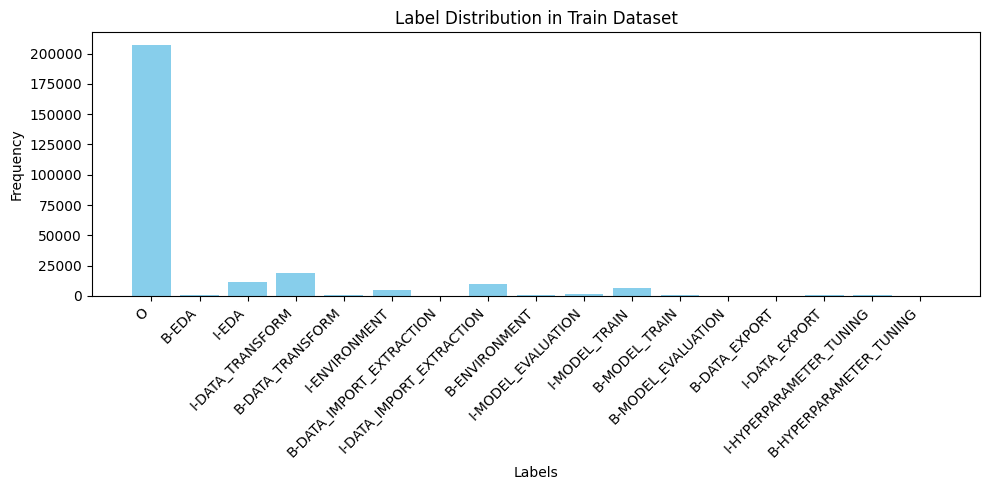

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

def analyze_label_distribution(dataset, id2label):
    label_counter = Counter()
    total_tokens = 0

    for item in dataset:
        labels = item['labels']
        for label_id in labels:
            if label_id != -100:  # skip special tokens
                label_name = id2label[label_id]
                label_counter[label_name] += 1
                total_tokens += 1

    print("Total labeled tokens:", total_tokens)
    print("Label distribution:")
    for label, count in label_counter.items():
        print(f"{label:25}: {count} ({count / total_tokens:.2%})")

    # Plot
    plt.figure(figsize=(10, 5))
    labels, counts = zip(*label_counter.items())
    plt.bar(labels, counts, color='skyblue')
    plt.title("Label Distribution in Train Dataset")
    plt.xlabel("Labels")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Call it:
analyze_label_distribution(train_dataset, id2label)


## Training

In [ ]:

# Data collator
from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(tokenizer)

# Training arguments
training_args = TrainingArguments(
    output_dir="./graphcodebert_ner_results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    save_steps=500,
    save_total_limit=2,
    remove_unused_columns=False,  # Important for our custom dataset
    disable_tqdm=False,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Save the model
model.save_pretrained("./graphcodebert_ner_model")
tokenizer.save_pretrained("./graphcodebert_ner_model")

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-23-1d1ffc1cf0ef>:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.062700,0.538877,0.021889,0.044706,0.029389,0.833362
2,0.585400,0.481031,0.051546,0.105882,0.069337,0.840967
3,0.420100,0.440868,0.069010,0.124706,0.088852,0.850769


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


('./graphcodebert_ner_model/tokenizer_config.json',
 './graphcodebert_ner_model/special_tokens_map.json',
 './graphcodebert_ner_model/vocab.json',
 './graphcodebert_ner_model/merges.txt',
 './graphcodebert_ner_model/added_tokens.json',
 './graphcodebert_ner_model/tokenizer.json')

## Plot confusion matrices

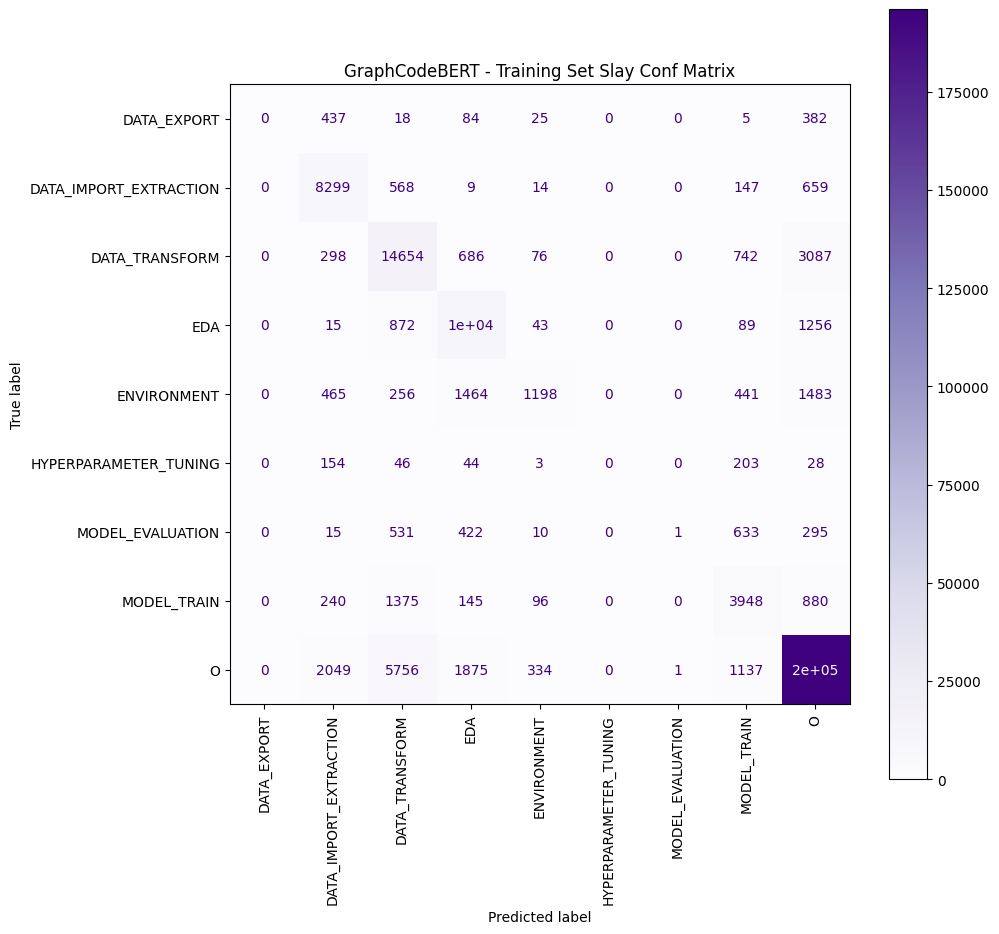

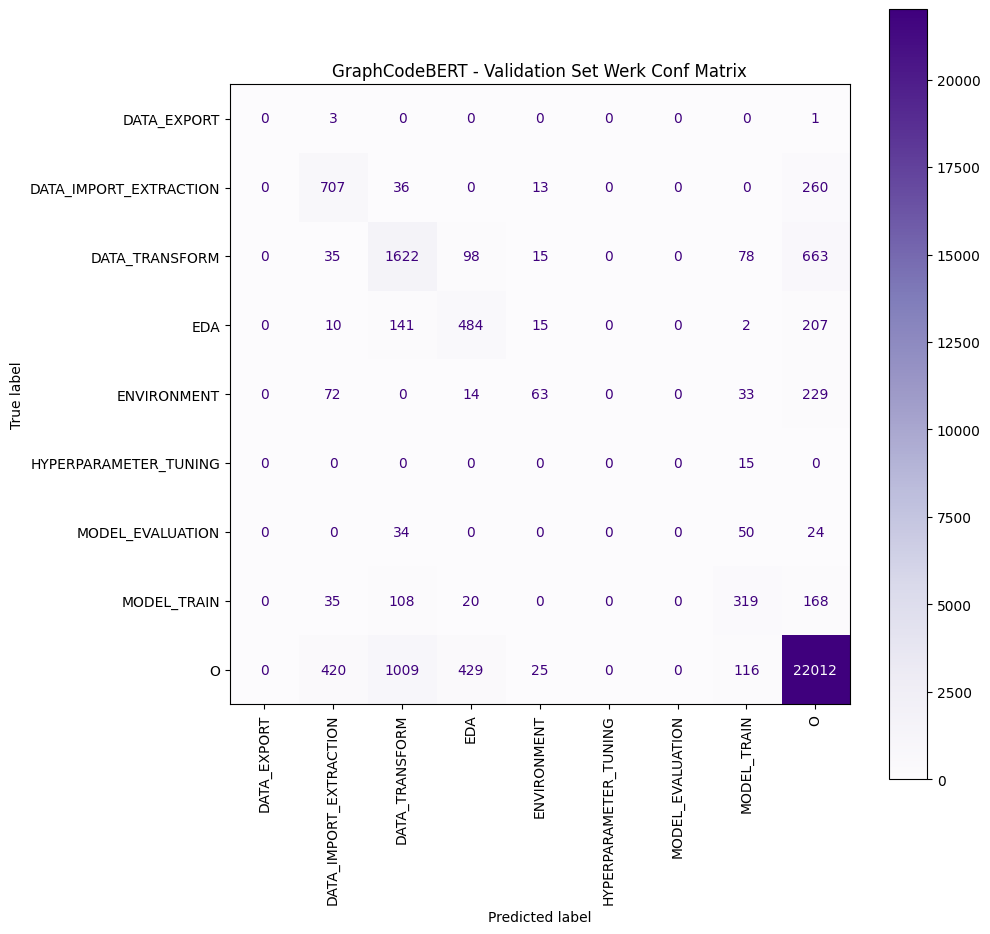

In [ ]:
plot_confusion_matrix(
    train_dataset,
    model,
    tokenizer,
    id2label,
    name="GraphCodeBERT - Training Set Slay Conf Matrix"
)

plot_confusion_matrix(
    val_dataset,
    model,
    tokenizer,
    id2label,
    name="GraphCodeBERT - Validation Set Werk Conf Matrix"
)


## Explicid per-class metric computation

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

def strip_prefix(label_id, id2label):
    """ Strips B-/I- from label and returns unified class. """
    label = id2label[label_id]
    if label == "O":
        return "O"
    # Remove B- or I-
    return label.split("-", 1)[-1]

def compute_subclass_metrics(p, id2label, zero_division=1):
    predictions, labels = p

    # Strip prefixes from the labels and predictions
    true_labels = [strip_prefix(label, id2label) for label in labels]
    pred_labels = [strip_prefix(pred, id2label) for pred in predictions]

    # Flatten the lists of true and predicted labels
    true_flat = np.array(true_labels).flatten()
    pred_flat = np.array(pred_labels).flatten()

    # We can exclude 'O' labels for the computation
    mask = true_flat != "O"  # O is for 'Outside' entity, we don't care about it here
    true_flat = true_flat[mask]
    pred_flat = pred_flat[mask]

    precision, recall, f1, support = precision_recall_fscore_support(
        true_flat, pred_flat, average=None, labels=np.unique(true_flat), zero_division=zero_division
    )

    # Convert results to a readable dictionary format
    metrics = {}
    for label, p, r, f, s in zip(np.unique(true_flat), precision, recall, f1, support):
        metrics[str(label)] = {
            "precision": round(float(p), 3),
            "recall": round(float(r), 3),
            "f1": round(float(f), 3),
            "support": int(s)
        }
    return metrics


In [ ]:
def get_predictions_and_labels(model, dataset, data_collator, device="cuda"):
    # Initialize lists to store predictions and true labels
    preds = []
    trues = []

    # Create a DataLoader to iterate over your dataset
    loader = torch.utils.data.DataLoader(dataset, batch_size=8, collate_fn=data_collator)

    # Set the model to evaluation mode
    model.eval()
    model.to(device)

    with torch.no_grad():
        # Loop over the dataset in batches
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass through the model
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # Get predictions by selecting the max logit for each token
            predictions = torch.argmax(logits, dim=-1)

            # Collect predictions and true labels for each sequence in the batch
            for pred_seq, true_seq in zip(predictions.cpu().numpy(), labels.cpu().numpy()):
                for p, t in zip(pred_seq, true_seq):
                    if t == -100:  # Skip ignored tokens
                        continue
                    preds.append(p)  # Add prediction
                    trues.append(t)  # Add true label

    return preds, trues


### Explicit on train set

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
predictions_train, labels_train = get_predictions_and_labels(model, train_dataset, data_collator, device)
predictions_val, labels_val = get_predictions_and_labels(model, val_dataset, data_collator, device)
metrics_train = compute_subclass_metrics((predictions_train, labels_train), id2label)
metrics_val = compute_subclass_metrics((predictions_val, labels_val), id2label)

NameError: name 'torch' is not defined

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

def display_metrics(metrics_train, metrics_val):
    metrics = []

    for label in metrics_train:
        metrics.append({
            "Class": label,
            "Train Precision": metrics_train[label]['precision'],
            "Train Recall": metrics_train[label]['recall'],
            "Train F1": metrics_train[label]['f1'],
            "Train Support": metrics_train[label]['support'],
            "Val Precision": metrics_val.get(label, {}).get('precision', np.nan),
            "Val Recall": metrics_val.get(label, {}).get('recall', np.nan),
            "Val F1": metrics_val.get(label, {}).get('f1', np.nan),
            "Val Support": metrics_val.get(label, {}).get('support', np.nan)
        })

    df_metrics = pd.DataFrame(metrics)

    # Function to apply a color scale to the metrics
    def colorize(val):
        if pd.isna(val):
            return 'background-color: lightgrey'
        if val >= 0.85:
            return 'background-color: #C1E1C1'  # light green
        elif val >= 0.5:
            return 'background-color: #F9E79F'  # yellow
        elif val >= 0.3:
            return 'background-color: #F4CCCC'  # light red
        else:
            return 'background-color: #F9B7B7'  # dark red

    styled_df = df_metrics.style.applymap(colorize, subset=['Train Precision', 'Train Recall', 'Train F1',
                                                            'Val Precision', 'Val Recall', 'Val F1'])
    return styled_df

display_metrics(metrics_train, metrics_val)


**Precision** is the ratio of correctly predicted positive observations to the total predicted positives, **Recall** is the ratio of correctly predicted positive observations to all actual positives, **F1-Score** is the harmonic mean of Precision and Recall, and **Support** is the number of actual occurrences of each class in the dataset.

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np

def compute_accuracy_excl_O(preds, labels, id2label):
    pred_labels = []
    true_labels = []

    for p, t in zip(preds, labels):
        if t == -100:
            continue
        true_tag = id2label[int(t)]
        pred_tag = id2label[int(p)]
        if true_tag != "O":
            true_labels.append(true_tag)
            pred_labels.append(pred_tag)

    return accuracy_score(true_labels, pred_labels)

acc_train_excl_O = compute_accuracy_excl_O(predictions_train, labels_train, id2label)
acc_val_excl_O = compute_accuracy_excl_O(predictions_val, labels_val, id2label)

print(f"🟢 Train Accuracy (excluding 'O'): {acc_train_excl_O:.4f}")
print(f"🔵 Val Accuracy (excluding 'O'): {acc_val_excl_O:.4f}")
